# Using Pyspark to Predict General Anime Score

In [1]:
from sklearn.preprocessing import MultiLabelBinarizer

from pyspark.sql.types import *
from pyspark.sql import Window
from pyspark.sql import functions as f


from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('anime-data').getOrCreate()

RuntimeError: Java gateway process exited before sending its port number

In [2]:
anime_schema = StructType(fields=[StructField('MAL_ID', IntegerType()),
                           StructField('name', StringType()),
                            StructField('score', DoubleType()),
                            StructField('genres', StringType()),
                            StructField('synopsis', StringType())
                           ])


animelist_schema = StructType(fields=[StructField('user_id', IntegerType()),
                           StructField('anime_id', IntegerType()),
                            StructField('rating', IntegerType()),
                            StructField('watching_status', IntegerType()),
                            StructField('watched_episodes', IntegerType())
                           ])

In [3]:
anime = spark.read.csv('gs://big_data_6893_zw2781/archive/anime_with_synopsis.csv', 
              schema=anime_schema,
              sep=',',
              header=True)

animelist = spark.read.csv('gs://big_data_6893_zw2781/archive/animelist.csv', 
              schema=animelist_schema,
              sep=',',
              header=True)

# Show best anime based on score

In [4]:
best_anime = anime\
            .filter('score is not null')\
            .withColumnRenamed('MAL_ID', 'anime_id')\
            .orderBy('score', ascending=False)\
            .cache()

best_anime.show(10)

+--------+--------------------+-----+--------------------+--------------------+
|anime_id|                name|score|              genres|            synopsis|
+--------+--------------------+-----+--------------------+--------------------+
|    5114|Fullmetal Alchemi...| 9.19|Action, Military,...|"""In order for s...|
|   40028|Shingeki no Kyoji...| 9.17|Action, Military,...|Gabi Braun and Fa...|
|    9253|         Steins;Gate| 9.11|    Thriller, Sci-Fi|"The self-proclai...|
|   11061|Hunter x Hunter (...|  9.1|Action, Adventure...|Hunter x Hunter i...|
|   28977|            Gintama°|  9.1|Action, Comedy, H...|Gintoki, Shinpach...|
|   38524|Shingeki no Kyoji...|  9.1|Action, Drama, Fa...|"Seeking to resto...|
|    9969|            Gintama'| 9.08|Action, Sci-Fi, C...|fter a one-year h...|
|     820|Ginga Eiyuu Densetsu| 9.07|Military, Sci-Fi,...|The 150-year-long...|
|   15417| Gintama': Enchousen| 9.04|Action, Comedy, H...|hile Gintoki Saka...|
|   28851|      Koe no Katachi|  9.0|Dra

In [5]:
best_anime_pandas = best_anime.toPandas()
best_anime_pandas.head(10)

,anime_id,name,score,genres,synopsis
0,5114,Fullmetal Alchemist: Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...","""""""In order for something to be obtained"
1,40028,Shingeki no Kyojin: The Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",Gabi Braun and Falco Grice have been training ...
2,9253,Steins;Gate,9.11,"Thriller, Sci-Fi","""The self-proclaimed mad scientist Rintarou Ok..."
3,11061,Hunter x Hunter (2011),9.10,"Action, Adventure, Fantasy, Shounen, Super Power",Hunter x Hunter is set in a world where Hunter...
4,28977,Gintama°,9.10,"Action, Comedy, Historical, Parody, Samurai, S...","Gintoki, Shinpachi, and Kagura return as the f..."
5,38524,Shingeki no Kyojin Season 3 Part 2,9.10,"Action, Drama, Fantasy, Military, Mystery, Sho...","""Seeking to restore humanity's diminishing hop..."
6,9969,Gintama',9.08,"Action, Sci-Fi, Comedy, Historical, Parody, Sa...","fter a one-year hiatus, Shinpachi Shimura retu..."
7,820,Ginga Eiyuu Densetsu,9.07,"Military, Sci-Fi, Space, Drama",The 150-year-long stalemate between the two in...
8,15417,Gintama': Enchousen,9.04,"Action, Comedy, Historical, Parody, Samurai, S...","hile Gintoki Sakata was away, the Yorozuya fou..."
9,28851,Koe no Katachi,9.00,"Drama, School, Shounen","s a wild youth, elementary school student Shou..."


# Genre analysis

In [6]:
popular_genres = anime.withColumn('genres_list', f.split('genres', ','))\
                     .withColumn('genre', f.explode('genres_list'))\
                     .groupBy('genre')\
                     .agg(f.count(f.col('name')).alias('genre_count'), f.avg(f.col('score')).alias('avg_score'))\
                     .orderBy('genre_count', ascending=False)\
                    .withColumn('pct_of_total', f.col('genre_count') / f.sum('genre_count').over(Window.partitionBy()))\
                    .withColumn('pct_of_total', f.col('pct_of_total') * 100)\
                    .cache()

popular_genres.show(10)

21/11/30 19:22:09 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+-------------+-----------+------------------+------------------+
|        genre|genre_count|         avg_score|      pct_of_total|
+-------------+-----------+------------------+------------------+
|       Action|       3846| 6.762866748166266| 7.983559596462822|
|       Comedy|       2884|  6.83221335573289| 5.986631793083406|
|       Sci-Fi|       2019|6.6796624713958765| 4.191057416863869|
|        Drama|       1799|  7.06344262295082|3.7343795408311538|
|         Kids|       1584| 6.305735027223229|3.2880807074355465|
|       School|       1529| 6.938985074626863|3.1739112384273676|
|    Adventure|       1473| 6.813311312964486| 3.057665960891767|
|        Mecha|       1010| 6.648888888888887| 2.096566612695645|
|Slice of Life|        968| 6.756351351351351| 2.009382654543945|
|        Magic|        948|   6.8275900621118|1.9678664839955162|
+-------------+-----------+------------------+------------------+
only showing top 10 rows



In [7]:
popular_genres.select(f.sum(popular_genres['pct_of_total']).alias('pct_sum')).show()

+-----------------+
|          pct_sum|
+-----------------+
|99.99999999999999|
+-----------------+



In [8]:
anime_10th_ptile = anime.filter('score is not null')\
            .select('name', 'genres', 'score', f.percent_rank().over(Window.partitionBy().orderBy(anime['score'])).alias('pct_rank'))\
            .filter('pct_rank >= 0.9')\

popular_genres_10th_ptile = anime_10th_ptile.withColumn('genres_list', f.split('genres', ','))\
             .withColumn('genre', f.explode('genres_list'))\
             .groupBy('genre')\
             .agg(f.count(f.col('name')).alias('genre_count'), f.avg(f.col('score')).alias('avg_score'))\
             .orderBy('genre_count', ascending=False)\
            .withColumn('pct_of_total', f.col('genre_count') / f.sum('genre_count').over(Window.partitionBy()))\
            .withColumn('pct_of_total', f.col('pct_of_total') * 100)\
            .cache()

popular_compare = popular_genres[['genre', 'pct_of_total']].withColumnRenamed('pct_of_total', 'pct_of_total_left')\
    .join(popular_genres_10th_ptile[['genre', 'pct_of_total']].withColumnRenamed('pct_of_total', 'pct_of_total_right'), on='genre', how='left')\
    .withColumn('abs_difference', f.abs(f.col('pct_of_total_right') - f.col('pct_of_total_left')))\
    .orderBy('abs_difference', ascending=False)

popular_compare.show(10)

21/11/30 19:22:26 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
21/11/30 19:22:26 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+-------------+------------------+-------------------+------------------+
|        genre| pct_of_total_left| pct_of_total_right|    abs_difference|
+-------------+------------------+-------------------+------------------+
|        Drama|3.7343795408311538|  6.980620962700562|3.2462414218694082|
|         Kids|3.2880807074355465|0.22921441967076475| 3.058866287764782|
|      Shounen| 4.112176692821854|  6.813919566576371| 2.701742873754517|
|        Music|3.0140739818159172| 0.5417795374036257|2.4722944444122916|
|         Kids|2.2418732096151452|0.04167534903104814| 2.200197860584097|
|       Comedy|   6.4121725412048|  4.480100020837675|1.9320725203671252|
| Supernatural|  2.80026570349151|  4.605126067930819|1.8048603644393086|
|      Mystery|1.0897994768962511| 2.6880600125026044|1.5982605356063533|
|      Romance| 3.543405156308382| 4.7093144405084395|1.1659092842000573|
|       School|3.1739112384273676|  4.313398624713482|1.1394873862861146|
+-------------+------------------+----

In [9]:
popular_compare.select('genre').filter(f.col('pct_of_total_right').isNull()).show(10)

+------------+
|       genre|
+------------+
|       Mecha|
|      Parody|
|     Unknown|
|      Police|
| Super Power|
|      Seinen|
|  Shounen Ai|
|        Yaoi|
|Martial Arts|
|     Samurai|
+------------+
only showing top 10 rows



In [10]:
animelist.show(5)

+-------+--------+------+---------------+----------------+
|user_id|anime_id|rating|watching_status|watched_episodes|
+-------+--------+------+---------------+----------------+
|      0|      67|     9|              1|               1|
|      0|    6702|     7|              1|               4|
|      0|     242|    10|              1|               4|
|      0|    4898|     0|              1|               1|
|      0|      21|    10|              1|               0|
+-------+--------+------+---------------+----------------+
only showing top 5 rows



# Watched episode analysis

In [11]:
most_watched_anime = animelist.groupBy('anime_id')\
    .agg(f.count(f.col('user_id')).alias('user_cnt'),
         f.mean(f.col('rating')).alias('mean_rating'),
         f.stddev(f.col('rating')).alias('std_rating'),
         f.percentile_approx(f.col('rating'), 0.5).alias('median_rating'),
         f.mean(f.col('watched_episodes')).alias('mean_num_episodes'))\
    .orderBy('user_cnt', ascending=False)\
    .cache()
    

In [12]:
%%time
most_watched_anime.show(10)

+--------+--------+------------------+------------------+-------------+------------------+
|anime_id|user_cnt|       mean_rating|        std_rating|median_rating| mean_num_episodes|
+--------+--------+------------------+------------------+-------------+------------------+
|    1535|  238790| 7.060513421835085|3.5440124213064155|            8|33.582227061434736|
|   16498|  216767| 6.955048508306153|3.4775672581522987|            8| 22.66545645785567|
|   11757|  209919| 5.967449349511002| 3.398963373813621|            7| 22.26595496358119|
|    5114|  201611| 6.624102851530918| 4.208399650778187|            9| 49.60007142467425|
|    4224|  196190| 6.042402772822264| 3.881768201022249|            8| 20.88801162138743|
|    6547|  194652| 6.143219694634527|3.7855301933369194|            8|11.717958202330312|
|    1575|  193770| 6.461572998916241|3.9761002093332167|            8|21.316560871135884|
|    9253|  192783|  6.09311505682555|  4.39019939535265|            9|17.244777807171793|

# Combined sorting

In [13]:
anime_joined = best_anime\
    .join(most_watched_anime, on='anime_id', how='inner')\
    .orderBy('user_cnt', ascending=False)\
    .cache()

anime_joined.show(3, truncate=False, vertical=True)

-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [14]:
genres_list = [g['genre'].strip() for g in popular_genres.select('genre').collect()]
print('Unique genres: %s' % len(genres_list))

Unique genres: 83


# Binarize Genres

In [15]:
ml_bin = MultiLabelBinarizer()
ml_bin.fit([genres_list])

print(ml_bin.classes_[:10])
print(len(ml_bin.classes_))

['6.45' '7.14' 'Action' 'Adventure' 'Cars' 'Comedy' 'Dementia' 'Demons'
 'Drama' 'Ecchi']
44


In [16]:
def binarize_genres(entry, binarizer):
    entry_list = [el.strip() for el in entry.split(', ')]
    entry_list = [el for el in entry_list if el != '']
    entry_tpl = tuple(entry_list)
    vector = binarizer.transform([entry_tpl])
    return [int(i) for i in vector[0]]

In [17]:
binarize_genres_udf = f.udf(lambda x: binarize_genres(x, ml_bin), returnType=ArrayType(IntegerType()))
data = anime_joined\
    .withColumn('genres_binarized', binarize_genres_udf(f.col('genres')))\
    .select(['anime_id', 'genres_binarized', 'user_cnt', 'mean_num_episodes', 'score'])\
    .cache()

for idx, genre_name in enumerate(ml_bin.classes_):
    data = data.withColumn(f'genre_{idx}', f.col('genres_binarized').getItem(idx))
print(data.columns)

['anime_id', 'genres_binarized', 'user_cnt', 'mean_num_episodes', 'score', 'genre_0', 'genre_1', 'genre_2', 'genre_3', 'genre_4', 'genre_5', 'genre_6', 'genre_7', 'genre_8', 'genre_9', 'genre_10', 'genre_11', 'genre_12', 'genre_13', 'genre_14', 'genre_15', 'genre_16', 'genre_17', 'genre_18', 'genre_19', 'genre_20', 'genre_21', 'genre_22', 'genre_23', 'genre_24', 'genre_25', 'genre_26', 'genre_27', 'genre_28', 'genre_29', 'genre_30', 'genre_31', 'genre_32', 'genre_33', 'genre_34', 'genre_35', 'genre_36', 'genre_37', 'genre_38', 'genre_39', 'genre_40', 'genre_41', 'genre_42', 'genre_43']


In [18]:
data = data.drop('genres_binarized')

In [88]:
assembler = VectorAssembler(inputCols=data.drop('score').columns,
                            outputCol='features')

linreg = LinearRegression(featuresCol='features', labelCol='score',maxIter=20, regParam=0.3, elasticNetParam=0.8)

pipeline = Pipeline(stages=[assembler,
                           linreg])

# linear regression

In [93]:
pipeline_model = pipeline.fit(data)
result = pipeline_model.transform(data)
result.select('prediction', 'score').sample(0.1).show()

+------------------+-----+
|        prediction|score|
+------------------+-----+
| 8.043908097179159|  8.2|
| 7.976659535111251| 8.07|
| 7.863123586170315| 7.88|
| 7.798530046293256| 8.29|
| 7.788080958959096| 7.88|
| 7.681961072002094|  9.0|
| 7.645672768702066| 8.33|
| 7.603615417183953| 7.73|
| 7.587397281631708| 7.07|
|7.5762461884301375| 7.78|
|7.5311918118626915| 8.49|
|  7.42512592535703| 7.82|
| 7.352792320788001| 7.41|
| 7.341182223750045|  8.7|
| 7.328492117685303| 7.51|
| 7.309699960619217| 7.32|
| 7.293157822358936| 8.03|
| 7.290790802575229| 8.38|
| 7.260847552307572| 8.24|
| 7.256500515974756| 7.65|
+------------------+-----+
only showing top 20 rows



In [94]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(
           metricName="rmse", 
           labelCol="score", 
           predictionCol="prediction") 
accuracy1 = evaluator.evaluate(result)
print("Test set accuracy = " + str(accuracy1))

Test set accuracy = 0.8285689565013016


# Random Forest

In [95]:
from pyspark.ml.regression import RandomForestRegressor
rf = RandomForestRegressor(labelCol="score", featuresCol="features", numTrees=2,maxDepth=4)
pipeline = Pipeline(stages=[assembler,
                           rf])
pipeline_model = pipeline.fit(data)
prediction = pipeline_model.transform(data)
prediction.select('prediction', 'score').sample(0.1).show()


+-----------------+-----+
|       prediction|score|
+-----------------+-----+
|7.365164354836111| 8.11|
|7.365164354836111| 8.17|
|7.365164354836111| 8.45|
|7.365164354836111| 8.34|
|7.365164354836111| 7.65|
|6.936537322454742| 8.05|
|7.365164354836111| 8.59|
|7.365164354836111| 8.27|
|7.365164354836111| 8.38|
|6.936537322454742| 8.38|
|7.365164354836111|  7.5|
|6.936537322454742| 7.04|
|7.365164354836111| 8.24|
|7.365164354836111| 8.54|
|7.068988124175291| 7.54|
|6.936537322454742| 7.59|
|7.365164354836111| 8.07|
|7.365164354836111| 7.56|
|6.936537322454742| 8.51|
|6.936537322454742|  7.7|
+-----------------+-----+
only showing top 20 rows



In [96]:
evaluator = RegressionEvaluator(
           metricName="rmse", 
           labelCol="score", 
           predictionCol="prediction") 
accuracy2 = evaluator.evaluate(prediction)
print("Test set accuracy = " + str(accuracy2))

Test set accuracy = 0.6688581386733015


# Decision Trees

In [97]:
from pyspark.ml.regression import DecisionTreeRegressor
dt = DecisionTreeRegressor(labelCol="score", featuresCol="features",maxDepth=4, maxBins=32)
pipeline = Pipeline(stages=[assembler,
                           dt])
pipeline_model = pipeline.fit(data)
prediction = pipeline_model.transform(data)
prediction.select('prediction', 'score').sample(0.1).show()

+------------------+-----+
|        prediction|score|
+------------------+-----+
| 7.926541353383455| 8.48|
| 7.926541353383455| 8.83|
| 7.926541353383455| 8.91|
| 7.926541353383455| 7.68|
| 7.926541353383455| 8.29|
| 7.926541353383455| 8.37|
| 7.926541353383455| 7.73|
| 7.926541353383455| 8.12|
|7.1827659574468115| 7.33|
| 7.926541353383455| 8.05|
| 7.926541353383455| 8.64|
| 7.926541353383455| 8.35|
| 7.926541353383455| 7.77|
| 7.926541353383455| 8.59|
| 7.926541353383455| 8.03|
| 7.926541353383455| 7.92|
| 7.926541353383455| 8.09|
| 7.926541353383455| 8.29|
|7.1827659574468115| 7.65|
| 7.926541353383455| 8.78|
+------------------+-----+
only showing top 20 rows



In [98]:
evaluator = RegressionEvaluator(
           metricName="rmse", 
           labelCol="score", 
           predictionCol="prediction") 
accuracy3 = evaluator.evaluate(prediction)
print("Test set accuracy = " + str(accuracy3))

Test set accuracy = 0.632317042625172


# GBT

In [99]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(labelCol="score", featuresCol="features")
pipeline = Pipeline(stages=[assembler,
                           dt])
pipeline_model = pipeline.fit(data)
prediction = pipeline_model.transform(data)
prediction.select('prediction', 'score').sample(0.1).show()

+------------------+-----+
|        prediction|score|
+------------------+-----+
| 7.926541353383455| 8.72|
| 7.926541353383455| 7.54|
| 7.926541353383455| 8.36|
| 7.926541353383455| 8.96|
| 7.926541353383455| 7.88|
| 7.926541353383455| 7.15|
| 7.926541353383455| 8.38|
| 7.926541353383455| 8.37|
| 7.926541353383455| 8.78|
| 7.926541353383455| 7.53|
| 7.926541353383455| 7.83|
| 7.926541353383455| 8.29|
| 7.926541353383455| 7.64|
| 7.926541353383455| 8.67|
|7.1827659574468115| 7.27|
| 7.926541353383455| 8.25|
| 7.926541353383455| 7.49|
| 7.926541353383455| 8.69|
| 7.926541353383455| 8.59|
| 7.926541353383455| 8.07|
+------------------+-----+
only showing top 20 rows



In [100]:
evaluator = RegressionEvaluator(
           metricName="rmse", 
           labelCol="score", 
           predictionCol="prediction") 
accuracy4 = evaluator.evaluate(prediction)
print("Test set accuracy = " + str(accuracy4))

Test set accuracy = 0.632317042625172


# Summary

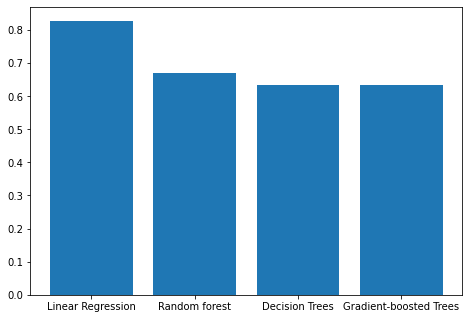

In [107]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ['Linear Regression', 'Random forest', 'Decision Trees', 'Gradient-boosted Trees']
accuracys = [accuracy1,accuracy2,accuracy3,accuracy4]
ax.bar(labels,accuracys)
plt.savefig('Content-based flitering algo models compare.png')

<Figure size 432x288 with 0 Axes>